In [2]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from utils.masks import extract_masks, binarize, resample_mask
from utils.images import normalize, resample_img
from utils.registration import est_lin_transf, apply_lin_transf, est_nl_transf, apply_nl_transf, seg_atlas
from utils.plot_methods import plot_transf, plot_atlas_seg

## Project 2

### Task 1 Atlas Creation

In [22]:
## Extract masks for common dataset

# Lists of masks
masks = ['./data/common_40_mask.nii.gz',
         './data/common_41_mask.nii.gz',
         './data/common_42_mask.nii.gz']

mov_masks_paths = ['./output/seed grow/common_40_mask_sg.nii.gz']

# Left femur - label 2, Left hip bone - label 4
labels = [3] 

# Extract masks
extract_masks(mov_masks_paths, labels)

The new mask is saved as './output/seed grow/common_40_mask_sg_3.nii.gz'.


Text(0.5, 1.0, 'Image and the new mask')

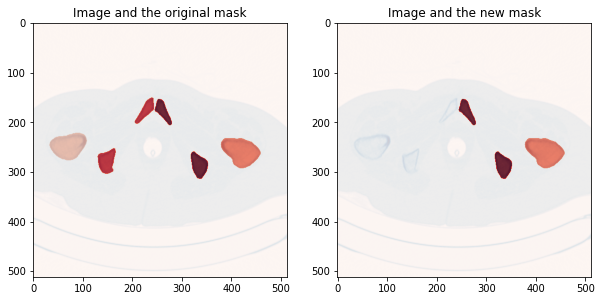

In [3]:
## Plot the extracted masks for one subject

# Load images
fix_img = sitk.ReadImage('./data/common_42_image.nii.gz', sitk.sitkFloat32)
fix_mask = sitk.ReadImage('./data/common_42_mask.nii.gz', sitk.sitkFloat32)
mask_new = sitk.ReadImage('./data/common_42_mask_4_2.nii.gz', sitk.sitkFloat32)

fix_img_data = sitk.GetArrayFromImage(fix_img)
fix_mask_data = sitk.GetArrayFromImage(fix_mask)
mask_new_data = sitk.GetArrayFromImage(mask_new)

# Plot original masks and extracted masks
idx = 30
plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(fix_img_data[idx], cmap='Blues') # fixed image
plt.imshow(fix_mask_data[idx], cmap = 'Reds', alpha = 0.8)
plt.title('Image and the original mask')

plt.subplot(122)
plt.imshow(fix_img_data[idx], cmap='Blues') # fixed image
plt.imshow(mask_new_data[idx], cmap = 'Reds', alpha = 0.8)
plt.title('Image and the new mask')

### Task 3 Atlas based-segmentation: (40%)

### Registration

In [3]:
def get_roi(img):
    thresh_mask = sitk.BinaryThreshold(img, lowerThreshold=450, upperThreshold=2500, insideValue=1, outsideValue=0)
    dilate_filter = sitk.BinaryDilateImageFilter()
    dilate_filter.SetKernelRadius(3)
    dilate_filter.SetKernelType(sitk.sitkBall)
    thresh_mask = dilate_filter.Execute(thresh_mask)
    return sitk.Cast(thresh_mask,sitk.sitkFloat32)

--------
Linear registration:
Final mean squares value: 167071.5973654347
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 35.
Number of iterations: 35
--------
--------
Demons registration:
Final metric value: 101937.59131692375
Optimizer stop condition: GradientDescentOptimizerv4Template: Maximum number of iterations (50) exceeded.
Number of iterations: 50
--------


/Users/xinyi/Documents/GitHub/Segmentationof-pelvic-bone-in-CT/utils/plot_methods.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


--------
Linear registration:
Final mean squares value: 188498.07642459974
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 17.
Number of iterations: 17
--------
--------
Demons registration:
Final metric value: 114158.74051912964
Optimizer stop condition: GradientDescentOptimizerv4Template: Maximum number of iterations (50) exceeded.
Number of iterations: 50
--------
--------
Linear registration:
Final mean squares value: 174230.57300819352
Optimizer stop condition: GradientDescentOptimizerv4Template: Maximum number of iterations (100) exceeded.
Number of iterations: 100
--------
--------
Demons registration:
Final metric value: 141230.25947305636
Optimizer stop condition: GradientDescentOptimizerv4Template: Maximum number of iterations (50) exceeded.
Number of iterations: 50
--------


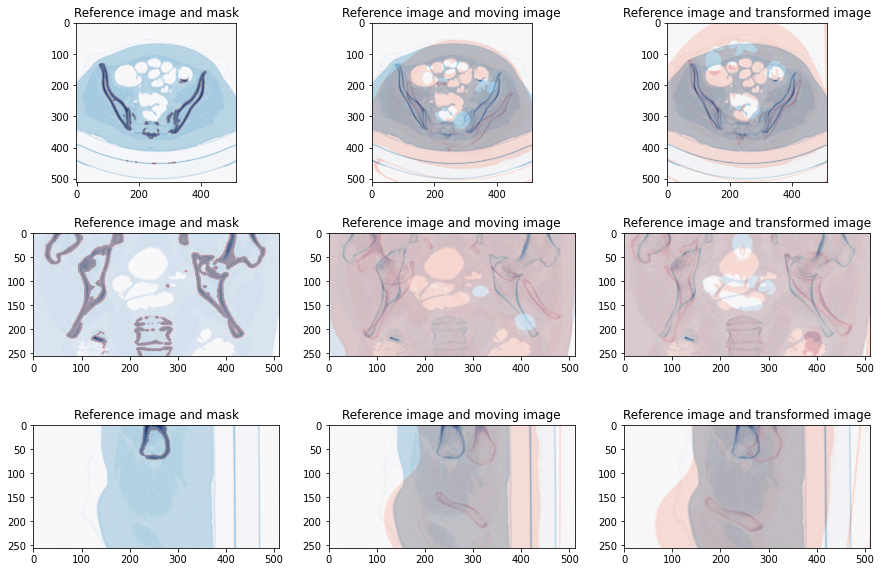

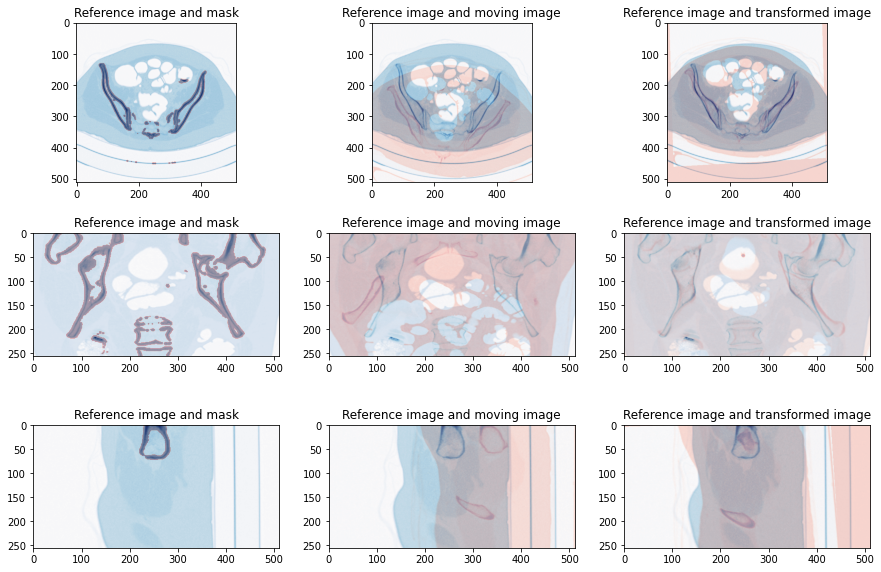

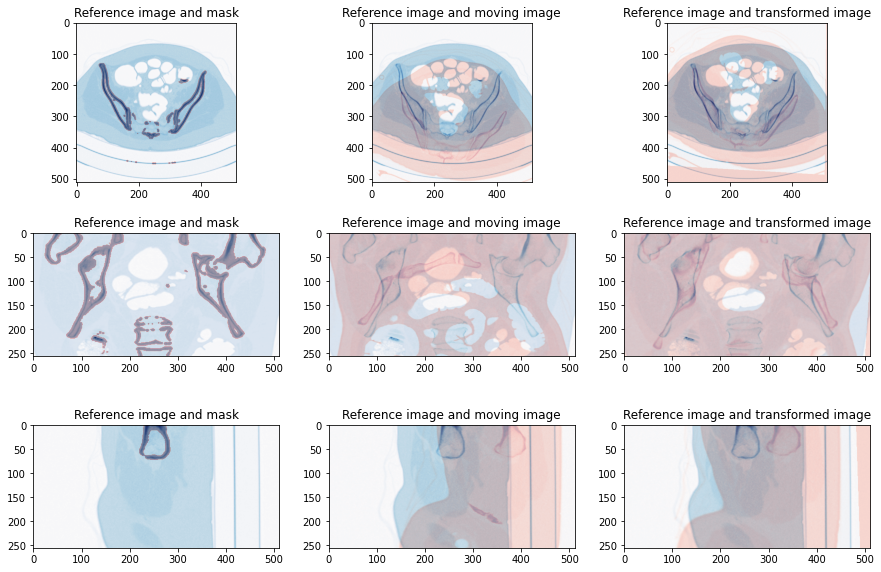

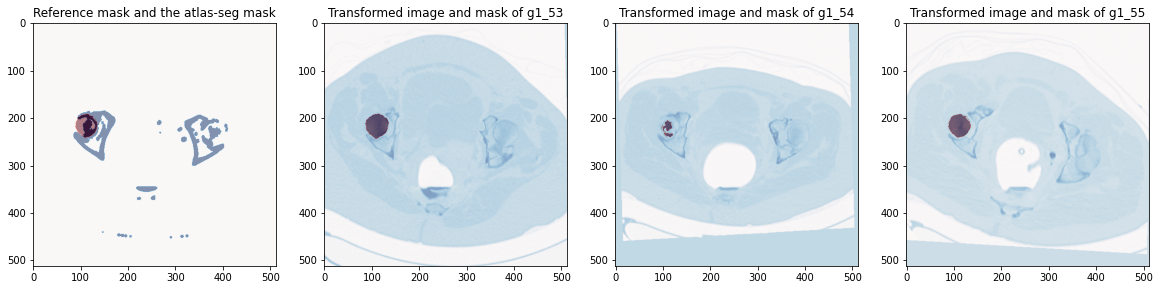

--------
Linear registration:
Final mean squares value: 166103.0660542483
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 53.
Number of iterations: 53
--------
--------
Demons registration:
Final metric value: 87549.24953803238
Optimizer stop condition: GradientDescentOptimizerv4Template: Maximum number of iterations (50) exceeded.
Number of iterations: 50
--------
--------
Linear registration:
Final mean squares value: 239991.9883184884
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 20.
Number of iterations: 20
--------
--------
Demons registration:
Final metric value: 194717.15942039425
Optimizer stop condition: GradientDescentOptimizerv4Template: Maximum number of iterations (50) exceeded.
Number of iterations: 50
--------
--------
Linear registration:
Final mean squares value: 196751.61532215623
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checke

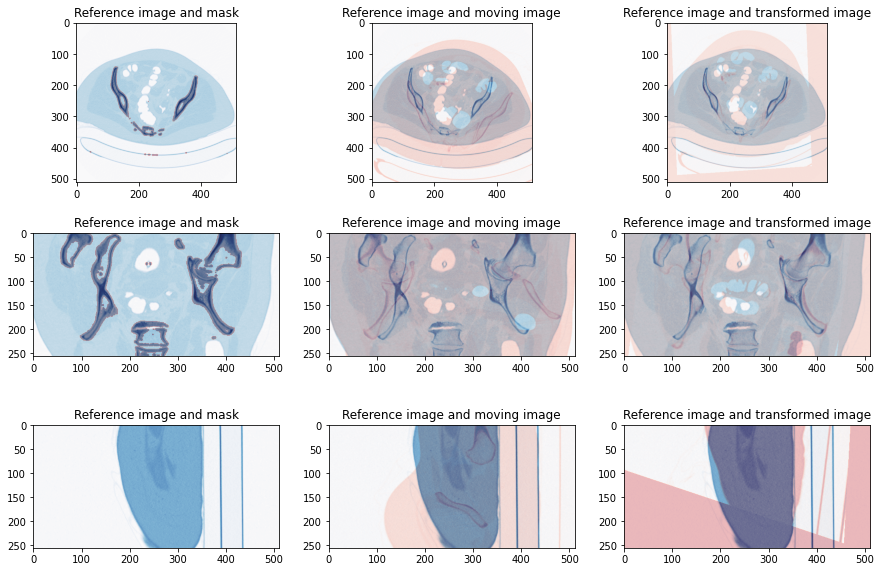

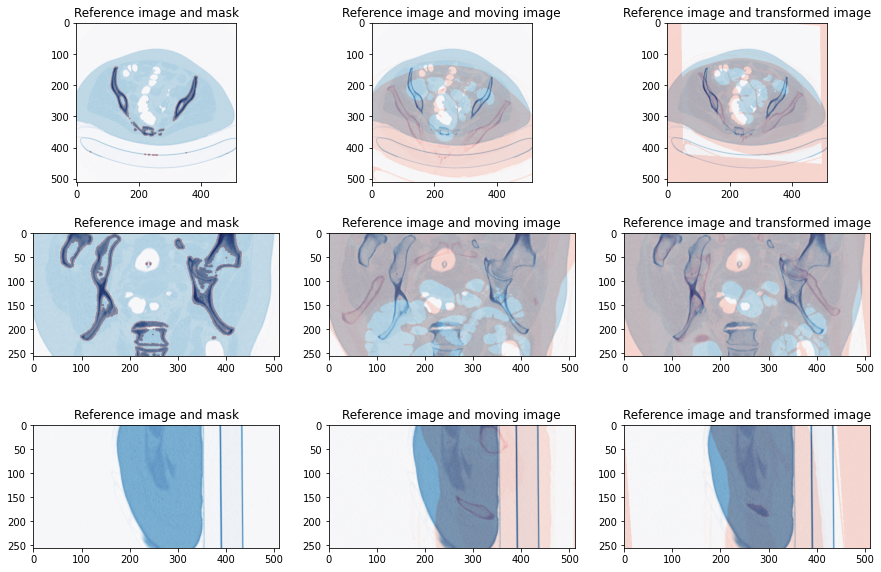

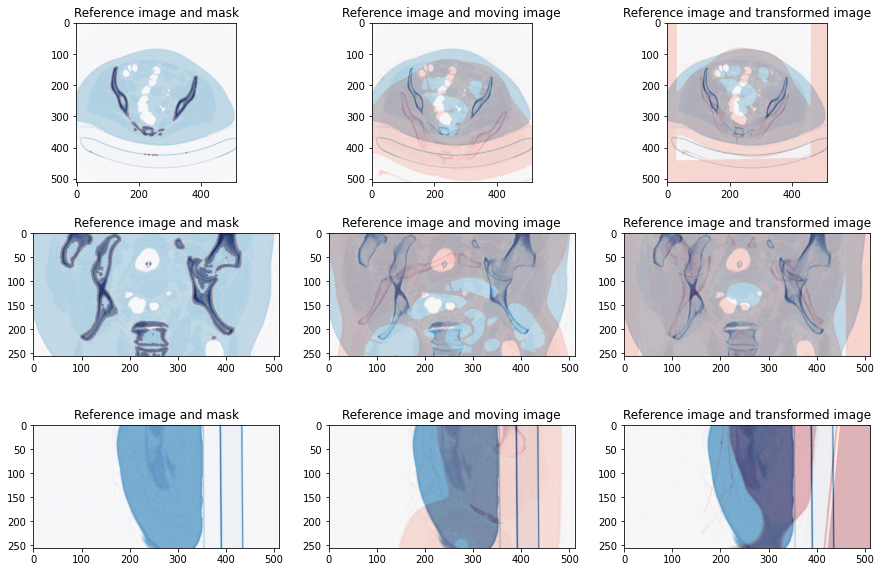

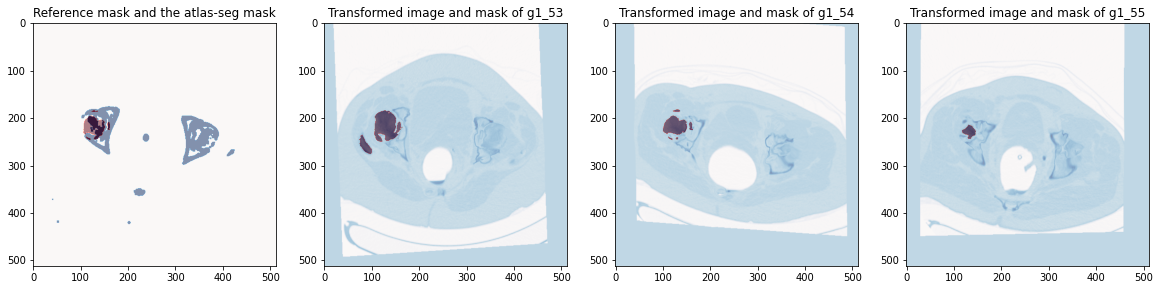

--------
Linear registration:
Final mean squares value: 181955.80501292404
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 24.
Number of iterations: 24
--------
--------
Demons registration:
Final metric value: 101186.25882660605
Optimizer stop condition: GradientDescentOptimizerv4Template: Maximum number of iterations (50) exceeded.
Number of iterations: 50
--------
--------
Linear registration:
Final mean squares value: 184636.0703236348
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 44.
Number of iterations: 44
--------
--------
Demons registration:
Final metric value: 156296.20764014608
Optimizer stop condition: GradientDescentOptimizerv4Template: Maximum number of iterations (50) exceeded.
Number of iterations: 50
--------
--------
Linear registration:
Final mean squares value: 180891.7029611788
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence check

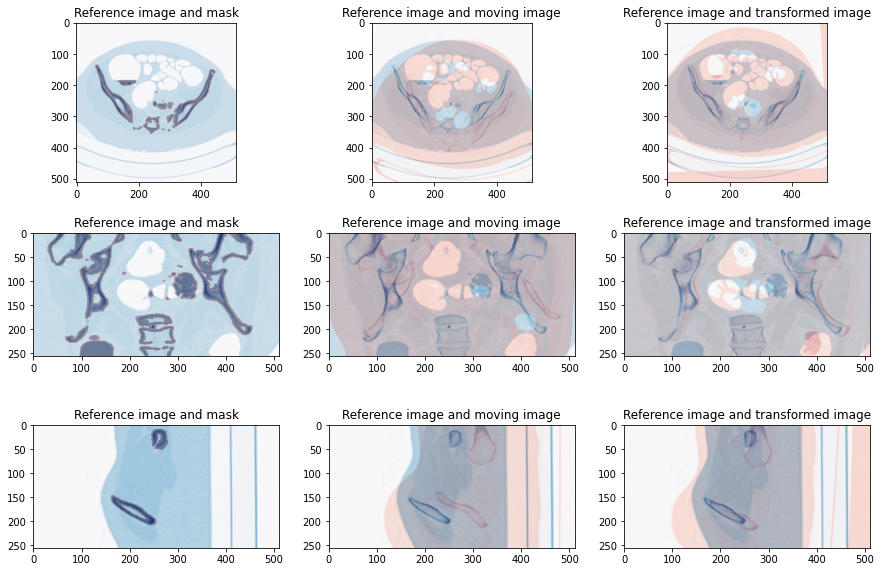

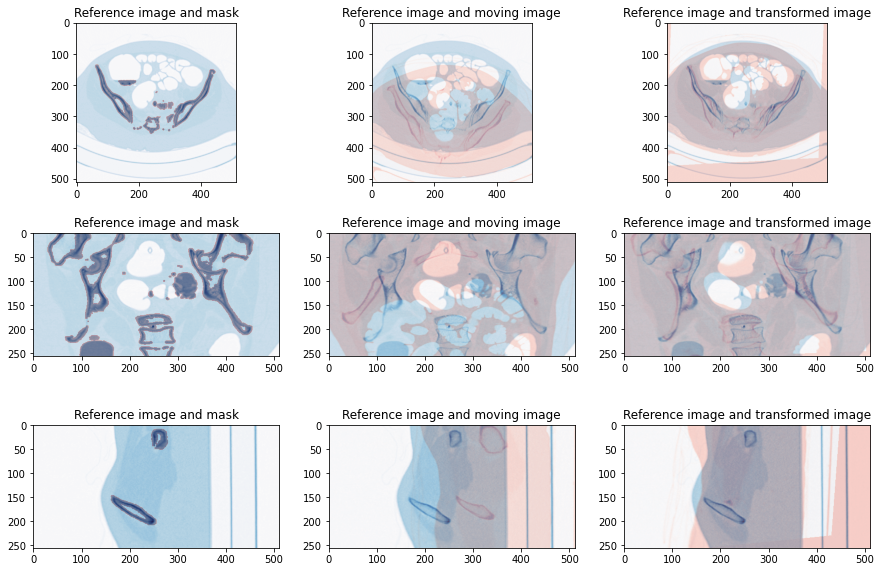

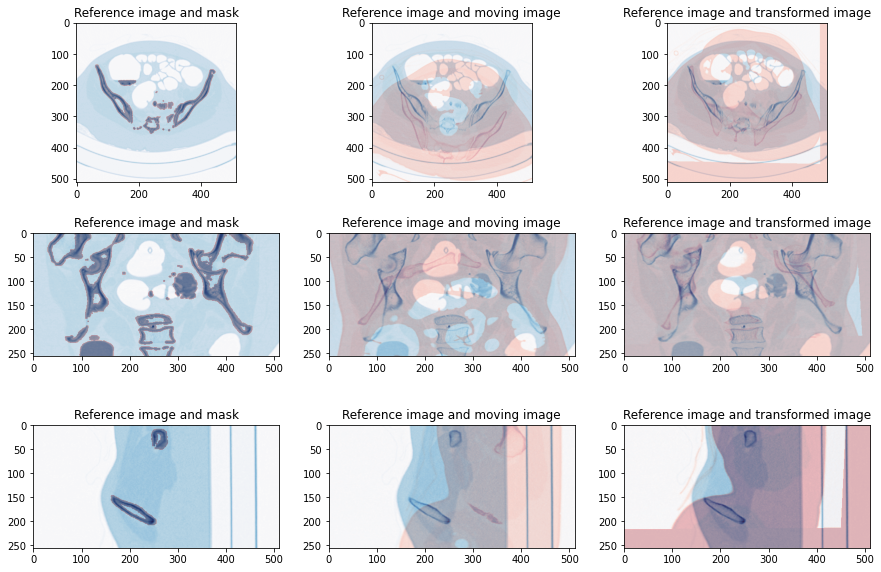

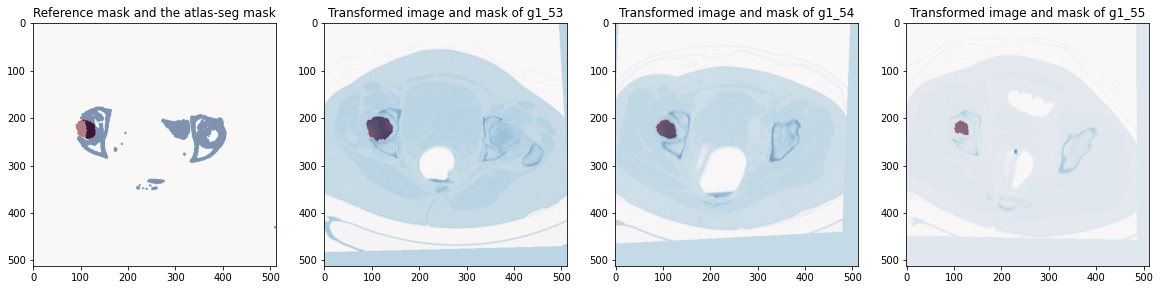

In [4]:
# If resample and normalize the images to be in the same size
resmaple = True
normal = False
# bones = ['r_femur', 'l_femur', 'r_hip', 'l_hip']
bones = ['r_femur']

common = [40, 41, 42]
group = [53, 54, 55]

for id_b in range(len(bones)):

    for i in range(len(common)):

        reg_masks = []
        reg_imgs = []

        # Load reference image and mask
        fix_img = sitk.ReadImage('./data/common_{0}_image.nii.gz'.format(common[i]), sitk.sitkFloat32)
        fix_mask = get_roi(fix_img)
        
        for j in range(len(group)):
            # Load moving image and mask
            mov_img = sitk.ReadImage('./data/g1_{0}_image.nii.gz'.format(group[j]), sitk.sitkFloat32)
            mov_mask = sitk.ReadImage('./data/g1_{0}_mask_{1}.nii.gz'.format(group[j],id_b+1), sitk.sitkFloat32)

            # Resample the images to be the same size
            # Normalize the images
            # Binarize the mask
            if resmaple:
                fix_img = resample_img(fix_img, out_size= [512,512,256])
                fix_mask = resample_mask(fix_mask, out_size= [512,512,256])
                mov_img = resample_img(mov_img, out_size= [512,512,256])
                mov_mask = resample_mask(mov_mask, out_size= [512,512,256])

            if normal:
                fix_img = normalize(fix_img)
                mov_img = normalize(mov_img)

            # Linear Registration
            lin_transf = est_lin_transf(fix_img, fix_mask, mov_img)
            lin_mov_img = apply_lin_transf(fix_img, mov_img, lin_transf)
            lin_mov_mask = apply_lin_transf(fix_img, mov_mask, lin_transf)

            # Demon Regisrtaion
            nl_transf = est_nl_transf(fix_img, lin_mov_img, fix_mask)
            nl_mov_img = apply_nl_transf(fix_img, lin_mov_img, nl_transf)
            nl_mov_mask = apply_nl_transf(fix_img, lin_mov_mask, nl_transf)

            reg_imgs.append(nl_mov_img)
            reg_masks.append(sitk.Cast(nl_mov_mask,sitk.sitkUInt8))

            # Plot the results
            x,y,z = 140, 250, 450
            plot_transf(fix_img, fix_mask, mov_img, lin_mov_img, x, y, z)

        # Apply atlas segmentation and save the image
        est_lin_mask = seg_atlas(reg_masks)
        est_lin_mask_path = './output/thresh/' + "common_{0}_".format(common[i]) + "fm_lin_est_{}_mask.nii.gz".format(bones[id_b])
        sitk.WriteImage(est_lin_mask, est_lin_mask_path)

        # Plot the atlas segmentation results
        idx = 80
        plot_atlas_seg(est_lin_mask, fix_mask, reg_imgs, reg_masks, idx)
        

In [11]:
lin_transf.GetNumberOfFixedParameters()

3

--------
Linear registration:
Final mean squares value: 174281.3582069663
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 26.
Number of iterations: 26
--------
--------
Demons registration:
Final metric value: 105581.23539225425
Optimizer stop condition: GradientDescentOptimizerv4Template: Maximum number of iterations (50) exceeded.
Number of iterations: 50
--------


/Users/xinyi/Documents/GitHub/Segmentationof-pelvic-bone-in-CT/utils/plot_methods.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


--------
Linear registration:
Final mean squares value: 203316.7232229302
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 12.
Number of iterations: 12
--------
--------
Demons registration:
Final metric value: 136719.1151596913
Optimizer stop condition: GradientDescentOptimizerv4Template: Maximum number of iterations (50) exceeded.
Number of iterations: 50
--------
--------
Linear registration:
Final mean squares value: 193749.9762452291
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 11.
Number of iterations: 11
--------
--------
Demons registration:
Final metric value: 142088.01707192376
Optimizer stop condition: GradientDescentOptimizerv4Template: Maximum number of iterations (50) exceeded.
Number of iterations: 50
--------


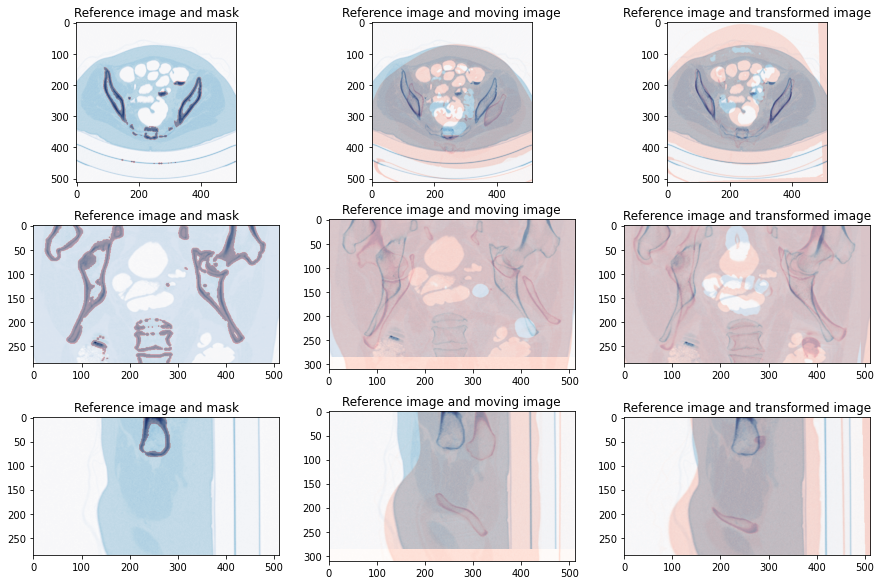

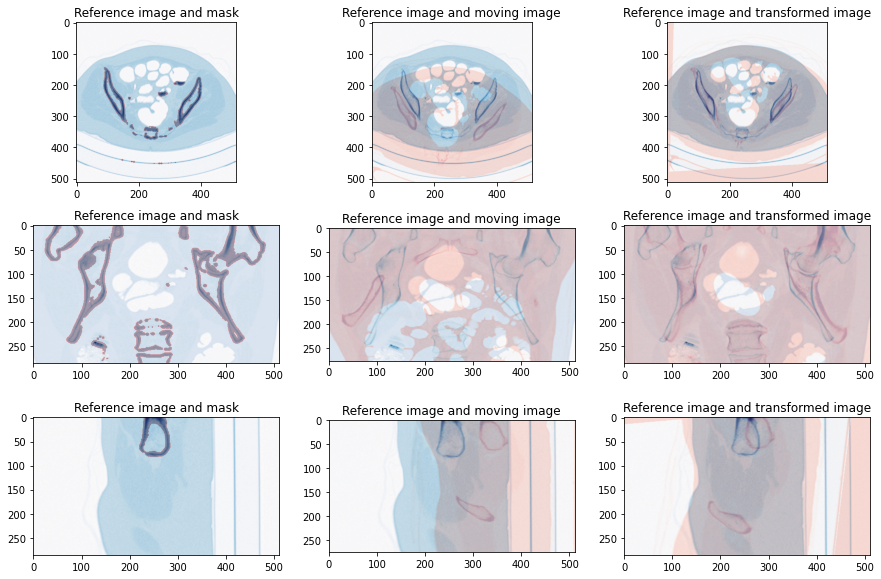

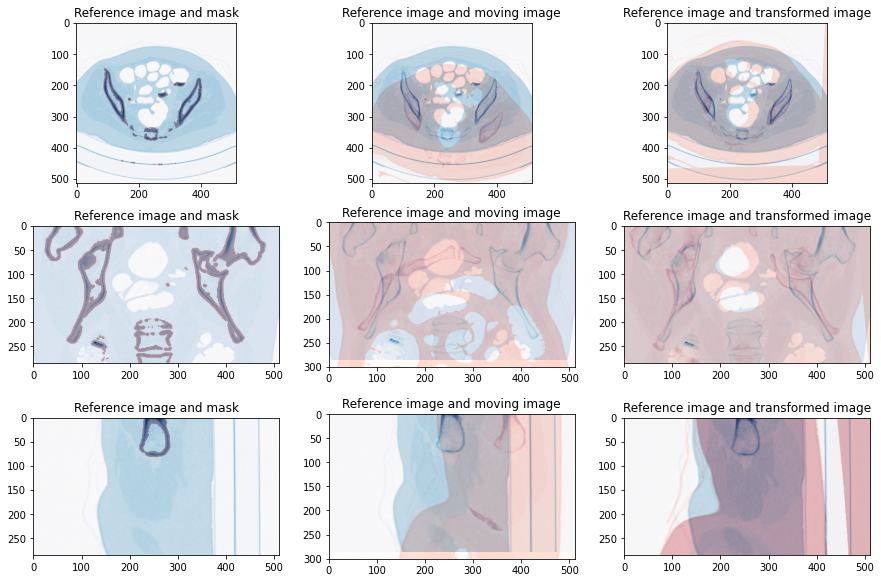

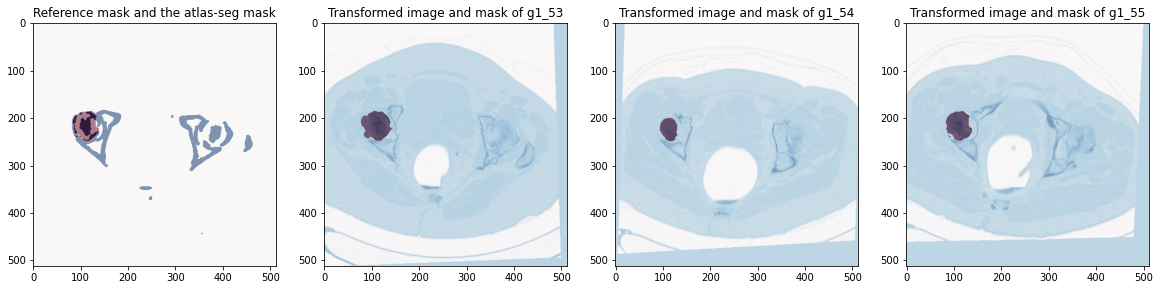

In [10]:
# If resample and normalize the images to be in the same size
resmaple = False
normal = False
# bones = ['r_femur', 'l_femur', 'r_hip', 'l_hip']
bones = ['r_femur']

common = [40]
group = [53, 54, 55]

for id_b in range(len(bones)):

    for i in range(len(common)):

        reg_masks = []
        reg_imgs = []

        # Load reference image and mask
        fix_img = sitk.ReadImage('./data/common_{0}_image.nii.gz'.format(common[i]), sitk.sitkFloat32)
        fix_mask = get_roi(fix_img)
        
        for j in range(len(group)):
            # Load moving image and mask
            mov_img = sitk.ReadImage('./data/g1_{0}_image.nii.gz'.format(group[j]), sitk.sitkFloat32)
            mov_mask = sitk.ReadImage('./data/g1_{0}_mask_{1}.nii.gz'.format(group[j],id_b+1), sitk.sitkFloat32)

            # Resample the images to be the same size
            # Normalize the images
            # Binarize the mask
            if resmaple:
                fix_img = resample_img(fix_img, out_size= [512,512,256])
                fix_mask = resample_mask(fix_mask, out_size= [512,512,256])
                mov_img = resample_img(mov_img, out_size= [512,512,256])
                mov_mask = resample_mask(mov_mask, out_size= [512,512,256])

            if normal:
                fix_img = normalize(fix_img)
                mov_img = normalize(mov_img)

            # Linear Registration
            lin_transf = est_lin_transf(fix_img, fix_mask, mov_img)
            lin_mov_img = apply_lin_transf(fix_img, mov_img, lin_transf)
            lin_mov_mask = apply_lin_transf(fix_img, mov_mask, lin_transf)

            # Demon Regisrtaion
            nl_transf = est_nl_transf(fix_img, lin_mov_img, fix_mask)
            nl_mov_img = apply_nl_transf(fix_img, lin_mov_img, nl_transf)
            nl_mov_mask = apply_nl_transf(fix_img, lin_mov_mask, nl_transf)

            reg_imgs.append(nl_mov_img)
            reg_masks.append(sitk.Cast(nl_mov_mask,sitk.sitkUInt8))

            # Plot the results
            x,y,z = 140, 250, 450
            plot_transf(fix_img, fix_mask, mov_img, lin_mov_img, x, y, z)

        # Apply atlas segmentation and save the image
        est_lin_mask = seg_atlas(reg_masks)
        est_lin_mask_path = './output/test/' + "common_{0}_".format(common[i]) + "fm_lin_est_{}_mask.nii.gz".format(bones[id_b])
        sitk.WriteImage(est_lin_mask, est_lin_mask_path)

        # Plot the atlas segmentation results
        idx = 80
        plot_atlas_seg(est_lin_mask, fix_mask, reg_imgs, reg_masks, idx)
        

In [13]:
# Define assesment method
def AccuracyAssess(ref, pred):

    labelTrue=ref
    labelPred=pred
    
    diceCoeff=sitk.LabelOverlapMeasuresImageFilter()
    diceCoeff.Execute(labelTrue>0.5,labelPred>0.5)

    hausDist=sitk.HausdorffDistanceImageFilter()
    hausDist.Execute(labelTrue>0.5,labelPred>0.5)

    print("Dice coefficient equal to ", diceCoeff.GetDiceCoefficient(), "; Hausdorff distance equal to ",  hausDist.GetHausdorffDistance())
    return diceCoeff.GetDiceCoefficient(), hausDist.GetHausdorffDistance()

In [15]:
dice_list = []
hausd_list = []
for id_b in range(len(bones)): 
    for i in common:
        gt = sitk.ReadImage('./data/common_{0}_mask_{1}.nii.gz'.format(i,id_b+1), sitk.sitkFloat32)
        est_mask = sitk.ReadImage('./output/test/common_{0}_fm_lin_est_{1}_mask.nii.gz'.format(i, bones[id_b]), sitk.sitkFloat32)
        # gt = resample_mask(gt, out_size= [512,512,256])
        print("Evaluation of the mask for {0} of common {1} :".format(bones[id_b], i))
        dice, hausd = AccuracyAssess(gt, sitk.Cast(est_mask,sitk.sitkUInt8))
        dice_list.append(dice)
        hausd_list.append(hausd_list)



Evaluation of the mask for r_femur of common 40 :
Dice coefficient equal to  0.8275733353062041 ; Hausdorff distance equal to  14.792536159321777


In [23]:
sg_mask = sitk.ReadImage('/Users/xinyi/Documents/GitHub/Segmentationof-pelvic-bone-in-CT/output/seed grow/common_40_mask_sg_3.nii.gz', sitk.sitkFloat32)
AccuracyAssess(gt, sitk.Cast(sg_mask,sitk.sitkUInt8))

Dice coefficient equal to  0.9489810025954112 ; Hausdorff distance equal to  4.0968645715653516


(0.9489810025954112, 4.0968645715653516)

### Task 4 Accuracy assessment: (10%)

In [3]:
# Define assesment method
def AccuracyAssess(ref, pred):

    labelTrue=ref
    labelPred=pred
    
    diceCoeff=sitk.LabelOverlapMeasuresImageFilter()
    diceCoeff.Execute(labelTrue>0.5,labelPred>0.5)

    hausDist=sitk.HausdorffDistanceImageFilter()
    hausDist.Execute(labelTrue>0.5,labelPred>0.5)

    print("Dice coefficient equal to ", diceCoeff.GetDiceCoefficient(), "; Hausdorff distance equal to ",  hausDist.GetHausdorffDistance())

In [4]:
for id_b in range(len(bones)): 
    for i in common:
        gt = sitk.ReadImage('./data/common_{0}_mask_{1}.nii.gz'.format(i,id_b+1), sitk.sitkFloat32)
        est_mask = sitk.ReadImage('./output/reg/common_{0}_fm_lin_est_{1}_mask.nii.gz'.format(i, bones[id_b]), sitk.sitkFloat32)
        gt = resample_mask(gt, out_size= [512,512,256])
        print("Evaluation of the mask for {0} of common {1} :".format(bones[id_b], i))
        AccuracyAssess(gt, sitk.Cast(est_mask,sitk.sitkUInt8))

Evaluation of the mask for r_femur of common 40 :
Dice coefficient equal to  0.8282343330569945 ; Hausdorff distance equal to  17.172390036652146
Evaluation of the mask for r_femur of common 41 :
Dice coefficient equal to  0.4759108395001518 ; Hausdorff distance equal to  22.060750697849468
Evaluation of the mask for r_femur of common 42 :
Dice coefficient equal to  0.6835400066369403 ; Hausdorff distance equal to  22.672893418299587
Evaluation of the mask for l_femur of common 40 :
Dice coefficient equal to  0.3046905985237455 ; Hausdorff distance equal to  31.628847284159168
Evaluation of the mask for l_femur of common 41 :
Dice coefficient equal to  0.39294268041852476 ; Hausdorff distance equal to  21.63153209544456
Evaluation of the mask for l_femur of common 42 :
Dice coefficient equal to  0.8405971274728123 ; Hausdorff distance equal to  14.359615105678824
Evaluation of the mask for r_hip of common 40 :
Dice coefficient equal to  0.8922097410226484 ; Hausdorff distance equal to 